# Probando conexion con la base de datos

In [3]:
pip install python-dotenv

  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import psycopg2
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Fetch variables
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Connect to the database
try:
    connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME
    )
    print("Connection successful!")
    
    # Create a cursor to execute SQL queries
    cursor = connection.cursor()
    
    # Example query
    cursor.execute("SELECT NOW();")
    result = cursor.fetchone()
    print("Current Time:", result)

    # Close the cursor and connection
    #cursor.close()
    #connection.close()
    #print("Connection closed.")

except Exception as e:
    print(f"Failed to connect: {e}")

Connection successful!
Current Time: (datetime.datetime(2025, 9, 29, 6, 20, 56, 854449, tzinfo=datetime.timezone.utc),)


## Listando tablas disponibles

In [7]:
cursor = connection.cursor()
cursor.execute("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public'
""")

tables = cursor.fetchall()
print("Tablas encontradas:")
for table in tables:
    print(table[0])

cursor.close()

Tablas encontradas:
n8n_chat_histories
airbnb_listings_final
geography_columns
geometry_columns
spatial_ref_sys
scraped_data
tweets_results
google_search
trivago_hoteles
facebook_posts


## Listando campos de la tabla facebook_posts

In [8]:
table_name = 'facebook_posts'  

cursor = connection.cursor()
cursor.execute("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = %s
""", (table_name,))

columns = cursor.fetchall()
print(f"Columnas en {table_name}:")
for column in columns:
    print(f"- {column[0]} ({column[1]})")

cursor.close()

Columnas en facebook_posts:
- comment_count (integer)
- view_count (integer)
- music (jsonb)
- reactions_count (integer)
- comments (jsonb)
- video (jsonb)
- created_at (timestamp with time zone)
- feedback_id (text)
- author_id (text)
- transcript (text)
- share_count (text)
- like_count (text)
- post_id (text)
- image_url (text)
- author (text)
- description (text)
- url (text)
- thumbnail (text)
- video_url (text)
- captions_url (text)


In [ ]:
pip install hdfs

# Seleccionamos la data y la almacenamos en memoria

In [1]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Fetch variables
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Conexión a tu base de datos
connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME
    )

table_name = 'facebook_posts'
query = f"SELECT * FROM {table_name};"

df = pd.read_sql(query, connection)
print(df.head())
connection.close()

/tmp/ipykernel_16452/3713557710.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


            post_id                  author  \
0   732574745273542      Luisito el das das   
1  1604314470532320             SC Gonzalez   
2  1467005400929895  Michel Dubraska Alfano   
3  2908275766022845         Rajib Choudhury   
4   941195313282924        কাঁচা মিঠে ট্যুর   

                                         description  \
0  Hoy les voy a mostrar un lugar muy bonito y es...   
1  If I have 4 days in Delhi … what are the place...   
2  I have one extra day in New Delhi, any ideas o...   
3                       India Gate 🇮🇳\n\n📍 New Delhi   
4  In this video i describe about 15 Top-Rated To...   

                                                 url  \
0  https://www.facebook.com/luisitodasdas1/videos...   
1  https://www.facebook.com/groups/38573540239023...   
2  https://www.facebook.com/groups/38573540239023...   
3  https://www.facebook.com/groups/15285565906614...   
4  https://www.facebook.com/109097457260426/video...   

                                           

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   post_id          31 non-null     object             
 1   author           31 non-null     object             
 2   description      29 non-null     object             
 3   url              31 non-null     object             
 4   thumbnail        2 non-null      object             
 5   video_url        2 non-null      object             
 6   captions_url     0 non-null      object             
 7   feedback_id      31 non-null     object             
 8   comment_count    31 non-null     int64              
 9   view_count       2 non-null      float64            
 10  reactions_count  31 non-null     int64              
 11  comments         31 non-null     object             
 12  created_at       31 non-null     datetime64[ns, UTC]
 13  author_id        29 no

# Procesamos los datos

## Api Facebook

In [11]:
import ast
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,when,regexp_replace, from_json, explode
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType,FloatType, TimestampType

In [46]:
# Iniciar Spark
spark = SparkSession.builder \
    .appName("FacebookPostsProcessing") \
    .getOrCreate()

schema = StructType([
    StructField("post_id", StringType(), True),
    StructField("author", StringType(), True),
    StructField("description", StringType(), True),
    StructField("url", StringType(), True),
    StructField("thumbnail", StringType(), True),
    StructField("video_url", StringType(), True),
    StructField("captions_url", StringType(), True),
    StructField("feedback_id", StringType(), True),
    StructField("comment_count", IntegerType(), True),
    StructField("view_count", FloatType(), True),
    StructField("reactions_count", IntegerType(), True),
    StructField("comments", StringType(), True),
    StructField("created_at", TimestampType(), True),
    StructField("author_id", StringType(), True),
    StructField("transcript", StringType(), True),
    StructField("music", StringType(), True),
    StructField("share_count", StringType(), True),
    StructField("like_count", StringType(), True),
    StructField("video", StringType(), True),
    StructField("image_url", StringType(), True)
])

raw_df = spark.createDataFrame(df, schema=schema)

# Ver esquema
raw_df.printSchema()

# Contar filas
print("Filas:", raw_df.count())

# Mostrar primeras filas
raw_df.show(5)

root
 |-- post_id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- description: string (nullable = true)
 |-- url: string (nullable = true)
 |-- thumbnail: string (nullable = true)
 |-- video_url: string (nullable = true)
 |-- captions_url: string (nullable = true)
 |-- feedback_id: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- view_count: float (nullable = true)
 |-- reactions_count: integer (nullable = true)
 |-- comments: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- author_id: string (nullable = true)
 |-- transcript: string (nullable = true)
 |-- music: string (nullable = true)
 |-- share_count: string (nullable = true)
 |-- like_count: string (nullable = true)
 |-- video: string (nullable = true)
 |-- image_url: string (nullable = true)

Filas: 31
+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+

In [12]:
raw_df.filter(col("description").isNull()).show()

+-----------------+---------------+-----------+--------------------+---------+---------+------------+--------------------+-------------+----------+---------------+--------------------+--------------------+---------------+----------+-----+-----------+----------+-----+---------+
|          post_id|         author|description|                 url|thumbnail|video_url|captions_url|         feedback_id|comment_count|view_count|reactions_count|            comments|          created_at|      author_id|transcript|music|share_count|like_count|video|image_url|
+-----------------+---------------+-----------+--------------------+---------+---------+------------+--------------------+-------------+----------+---------------+--------------------+--------------------+---------------+----------+-----+-----------+----------+-----+---------+
|31551441477836714|Turismo Mundial|       NULL|https://www.faceb...|     NULL|     NULL|        NULL|ZmVlZGJhY2s6MzE1N...|            0|       NaN|              4|   

### Seleccionamos las columnas que nos serviran

In [20]:
## Datos de post ##
posts_columns = [
    "post_id",
    "author",
    "description",
    "author_id",
    "created_at",
    "reactions_count",
    "comment_count"
]

posts_df = raw_df.select(*posts_columns)

# Revisar el resultado
posts_df.show(5)
posts_df.printSchema()

+----------------+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|         post_id|              author|         description|           author_id|          created_at|reactions_count|comment_count|
+----------------+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
| 732574745273542|  Luisito el das das|Hoy les voy a mos...|                NULL|2025-09-28 12:07:...|            970|           64|
|1604314470532320|         SC Gonzalez|If I have 4 days ...|pfbid0vhYgPJ17cS1...|2025-09-28 13:02:...|             29|           49|
|1467005400929895|Michel Dubraska A...|I have one extra ...|pfbid02cviEd6AFJD...|2025-09-28 13:02:...|             20|           16|
|2908275766022845|     Rajib Choudhury|India Gate 🇮🇳\n...|pfbid02Gr6Vq5Jj1B...|2025-09-28 13:03:...|             62|            2|
| 941195313282924|    কাঁচা মিঠে ট্যুর|In this video i d...|           

### Total de datos con descripción nula

In [21]:
posts_df.filter(col("description").isNull()).count()

2

### Eliminando datos con descripción nula

In [22]:
posts_df.filter(col("description").isNull()).show()

+-----------------+---------------+-----------+---------------+--------------------+---------------+-------------+
|          post_id|         author|description|      author_id|          created_at|reactions_count|comment_count|
+-----------------+---------------+-----------+---------------+--------------------+---------------+-------------+
|31551441477836714|Turismo Mundial|       NULL|100071967090707|2025-09-28 22:42:...|              4|            0|
| 2514063592259784|   Alexandro CC|       NULL|100012761652693|2025-09-28 23:00:...|             99|            6|
+-----------------+---------------+-----------+---------------+--------------------+---------------+-------------+



In [25]:
posts_df_nonull = posts_df.filter(posts_df.description.isNotNull())
posts_df_nonull.show()

+----------------+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|         post_id|              author|         description|           author_id|          created_at|reactions_count|comment_count|
+----------------+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
| 732574745273542|  Luisito el das das|Hoy les voy a mos...|                NULL|2025-09-28 12:07:...|            970|           64|
|1604314470532320|         SC Gonzalez|If I have 4 days ...|pfbid0vhYgPJ17cS1...|2025-09-28 13:02:...|             29|           49|
|1467005400929895|Michel Dubraska A...|I have one extra ...|pfbid02cviEd6AFJD...|2025-09-28 13:02:...|             20|           16|
|2908275766022845|     Rajib Choudhury|India Gate 🇮🇳\n...|pfbid02Gr6Vq5Jj1B...|2025-09-28 13:03:...|             62|            2|
| 941195313282924|    কাঁচা মিঠে ট্যুর|In this video i d...|           

In [24]:
posts_df_nonull.count()

29

### Eliminando duplicados

In [198]:
posts_final_df = posts_df_nonull.dropDuplicates(["post_id"])

# Mostrar resultado
posts_final_df.show()

+----------------+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|         post_id|              author|         description|           author_id|          created_at|reactions_count|comment_count|
+----------------+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|1027196462108337|         Mochileando|Así puedes organi...|     100044539774908|2025-09-28 23:02:...|           1452|          286|
|1114396044213087|       Mincetur Perú|🌍✨ ¡Feliz Día Mu...|     100069281046725|2025-09-28 22:43:...|            779|           21|
|1467005400929895|Michel Dubraska A...|I have one extra ...|pfbid02cviEd6AFJD...|2025-09-28 13:02:...|             20|           16|
|1578469652705907|        Sheila Boyle|Heading back to P...|pfbid0R3vak5wqW8w...|2025-09-28 20:33:...|              8|           20|
|1604314470532320|         SC Gonzalez|If I have 4 days ...|pfbid0vhYg

In [199]:
posts_final_df.count()

29

### Normalizando comentarios

In [177]:
from pyspark.sql.functions import col, regexp_replace, split, explode, regexp_extract,length, trim

#### Eliminar nulos

In [201]:
# Filtrar comentarios no nulos y no vacíos
raw_df_nonull = raw_df.filter(
    (col("comments").isNotNull()) & (length(trim(col("comments"))) > 2)  # >2 porque '[]' tiene longitud 2
)

#### Eliminar corchetes exteriores

In [202]:
# Limpiar corchetes exteriores
clean_df = raw_df_nonull.withColumn(
    "comments_clean",
    regexp_replace(col("comments"), r"^\[|\]$", "")
)

#### Separar comentarios

In [180]:
# Separar comentarios individuales por '},{'
exploded_df = clean_df.withColumn(
    "comment_single",
    explode(split(col("comments_clean"), r"\},\s*\{"))
)

#### Limpiar llaves sobrantes

In [181]:
exploded_df = exploded_df.withColumn(
    "comment_single",
    regexp_replace(col("comment_single"), r"^\{|\}$", "")
)

#### Limpiar la columna comment_single para manejar saltos de línea dentro de text

In [182]:
exploded_df = exploded_df.withColumn(
    "comment_clean",
    regexp_replace(col("comment_single"), r"\n", " ")  # reemplaza saltos de línea por espacio
)


#### Extraer los comentarios individuales

In [183]:
exploded_df = exploded_df.withColumn(
    "comment_single",
    explode(split(col("comment_clean"), r"\},\s*\{"))  # separa cada comentario
)

#### Extraer campos con regex

In [184]:
# Extraer campos con regex
final_df = exploded_df.select(
    col("post_id"),
    regexp_extract(col("comment_single"), r"id=([^,]+)", 1).alias("comment_id"),
    regexp_extract(col("comment_single"), r"text=(.*?)(?=, id=)", 1).alias("text"),
    regexp_extract(col("comment_single"), r"reaction_count=(\d+)", 1).alias("reaction_count"),
    regexp_extract(col("comment_single"), r"author=\{.*?id=([^,]+)", 1).alias("author_id"),
    regexp_extract(col("comment_single"), r"author=\{.*? name=([^,}]+)", 1).alias("author_name"),
    regexp_extract(col("comment_single"), r"author=\{.*?gender=([^,}]+)", 1).alias("author_gender")
)

#### Quitar espacios extras

In [185]:
final_df = final_df.select(
    [trim(col(c)).alias(c) for c in final_df.columns]
)

In [186]:
final_df.show()

+----------------+--------------------+--------------------+--------------+--------------------+--------------------+-------------+
|         post_id|          comment_id|                text|reaction_count|           author_id|         author_name|author_gender|
+----------------+--------------------+--------------------+--------------+--------------------+--------------------+-------------+
| 732574745273542|Y29tbWVudDo1ODY5M...|Muy Buenos días e...|             2|e99d92&_nc_ohc=fp...|       Leandro Vidal|         MALE|
| 732574745273542|Y29tbWVudDo1ODY5M...|Bonito lugar luis...|             1|e99d92&_nc_ohc=_o...|    Gonzalo Espinoza|         MALE|
|1604314470532320|Y29tbWVudDoxNjA0M...|Maybe..  Day 1 Qu...|             3|1d2534&_nc_ohc=ei...|Amanda Nabilla Kh...|       FEMALE|
|1604314470532320|Y29tbWVudDoxNjA0M...|           Rishikesh|             3|1d2534&_nc_ohc=4a...|           Ram Singh|         MALE|
|1604314470532320|Y29tbWVudDoxNjA0M...|2 places I would ...|             1|1

#### Aun despues de limpiar nos quedaba un comentario sin texto

In [187]:
single_post_df =  final_df.filter(col("post_id") == "2908275766022845")
# Seleccionar solo la columna comments y mostrarla
single_post_df.show()

+----------------+--------------------+--------------------+--------------+--------------------+-----------+-------------+
|         post_id|          comment_id|                text|reaction_count|           author_id|author_name|author_gender|
+----------------+--------------------+--------------------+--------------+--------------------+-----------+-------------+
|2908275766022845|Y29tbWVudDoyOTA4M...|We stayed in Delh...|             1|e99d92&_nc_ohc=ne...|Tanu Tanuja|       FEMALE|
|2908275766022845|Y29tbWVudDoyOTA4M...|                    |             1|e99d92&_nc_ohc=ne...|Tanu Tanuja|       FEMALE|
+----------------+--------------------+--------------------+--------------+--------------------+-----------+-------------+



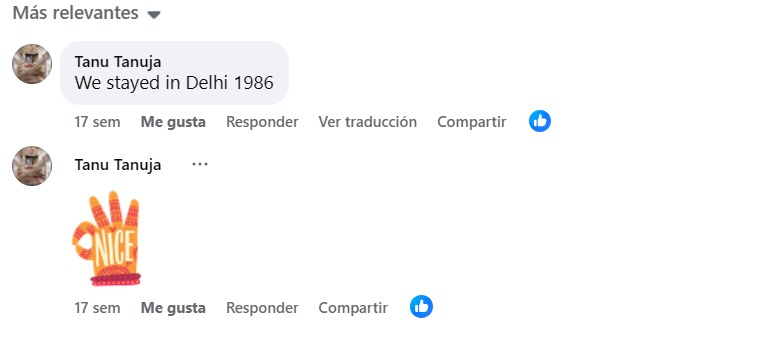

#### Eliminando comentarios que no poseen texto:

In [196]:
coments_final_df = final_df.filter(trim(col("text")) != "")
single_post_df =  final_df_limp.filter(col("post_id") == "2908275766022845")
# Seleccionar solo la columna comments y mostrarla
single_post_df.show()

+----------------+--------------------+--------------------+--------------+--------------------+-----------+-------------+
|         post_id|          comment_id|                text|reaction_count|           author_id|author_name|author_gender|
+----------------+--------------------+--------------------+--------------+--------------------+-----------+-------------+
|2908275766022845|Y29tbWVudDoyOTA4M...|We stayed in Delh...|             1|e99d92&_nc_ohc=ne...|Tanu Tanuja|       FEMALE|
+----------------+--------------------+--------------------+--------------+--------------------+-----------+-------------+



In [41]:
# Filtrar por post_id
single_post_df = raw_df.filter(col("post_id") == "606326448590140")

# Mostrar el registro completo
single_post_df.show()

+---------------+-----------+--------------------+--------------------+---------+---------+------------+--------------------+-------------+----------+---------------+--------------------+--------------------+---------------+----------+-----+-----------+----------+-----+---------+
|        post_id|     author|         description|                 url|thumbnail|video_url|captions_url|         feedback_id|comment_count|view_count|reactions_count|            comments|          created_at|      author_id|transcript|music|share_count|like_count|video|image_url|
+---------------+-----------+--------------------+--------------------+---------+---------+------------+--------------------+-------------+----------+---------------+--------------------+--------------------+---------------+----------+-----+-----------+----------+-----+---------+
|606326448590140|Forbes Perú|Los lugares más v...|https://www.faceb...|     NULL|     NULL|        NULL|ZmVlZGJhY2s6NjA2M...|            1|       NaN|       

In [39]:
# Reemplazar comillas simples por dobles en 'comments'
raw_df_clean = raw_df.withColumn(
    "comments_clean",
    regexp_replace("comments", "'", '"')
)

In [ ]:
single_post_df = raw_df.filter(col("post_id") == "606326448590140")

# Mostrar el registro completo
single_post_df.show(truncate=500)

In [41]:
raw_df_nonull = raw_df_clean.filter(raw_df_clean.comments_clean.isNotNull())

comments_schema = ArrayType(
    StructType([
        StructField("id", StringType(), True),
        StructField("text", StringType(), True),
        StructField("reaction_count", IntegerType(), True),
        StructField("author", StructType([
            StructField("id", StringType(), True),
            StructField("name", StringType(), True),
            StructField("gender", StringType(), True)
        ]))
    ])
)


In [48]:
from pyspark.sql.functions import col, regexp_replace, split, explode, regexp_extract
# 1. Limpiar corchetes exteriores
clean_df = raw_df_nonull.withColumn(
    "comments_clean2",
    regexp_replace(col("comments_clean"), r"^\[|\]$", "")
)

# 2. Separar comentarios individuales por '},{' (asumiendo formato JSON consistente)
exploded_df = clean_df.withColumn(
    "comment_single",
    explode(split(col("comments_clean2"), r"\},\s*\{"))
)

# 3. Agregar llaves faltantes en los extremos de cada fragmento
exploded_df = exploded_df.withColumn(
    "comment_single",
    regexp_replace(col("comment_single"), r"^", "{")
).withColumn(
    "comment_single",
    regexp_replace(col("comment_single"), r"$", "}")
)

# 4. Extraer campos de cada comentario usando regex
comments_final_df = exploded_df.select(
    col("post_id"),
    regexp_extract("comment_single", r'"id":\s*"([^"]+)"', 1).alias("comment_id"),
    regexp_extract("comment_single", r'"text":\s*"([^"]+)"', 1).alias("text"),
    regexp_extract("comment_single", r'"reaction_count":\s*(\d+)', 1).cast("int").alias("reaction_count"),
    regexp_extract("comment_single", r'"author":\s*\{[^}]*"id":\s*"([^"]+)"', 1).alias("author_id"),
    regexp_extract("comment_single", r'"author":\s*\{[^}]*"name":\s*"([^"]+)"', 1).alias("author_name"),
    regexp_extract("comment_single", r'"author":\s*\{[^}]*"gender":\s*"([^"]+)"', 1).alias("author_gender")
)

# 5. Mostrar resultado
# Filtrar por post_id
single_post_df = comments_final_df.filter(col("post_id") == "606326448590140")

# Mostrar el registro completo
single_post_df.show()

+---------------+--------------------+--------------------+--------------+---------------+-------------+-------------+
|        post_id|          comment_id|                text|reaction_count|      author_id|  author_name|author_gender|
+---------------+--------------------+--------------------+--------------+---------------+-------------+-------------+
|606326448590140|Y29tbWVudDo2MDYzM...|Hace falta más in...|             0|100048700500150|Paty Da Silva|       FEMALE|
+---------------+--------------------+--------------------+--------------+---------------+-------------+-------------+



In [197]:
coments_final_df.show()

+----------------+--------------------+--------------------+--------------+--------------------+--------------------+-------------+
|         post_id|          comment_id|                text|reaction_count|           author_id|         author_name|author_gender|
+----------------+--------------------+--------------------+--------------+--------------------+--------------------+-------------+
| 732574745273542|Y29tbWVudDo1ODY5M...|Muy Buenos días e...|             2|e99d92&_nc_ohc=fp...|       Leandro Vidal|         MALE|
| 732574745273542|Y29tbWVudDo1ODY5M...|Bonito lugar luis...|             1|e99d92&_nc_ohc=_o...|    Gonzalo Espinoza|         MALE|
|1604314470532320|Y29tbWVudDoxNjA0M...|Maybe..  Day 1 Qu...|             3|1d2534&_nc_ohc=ei...|Amanda Nabilla Kh...|       FEMALE|
|1604314470532320|Y29tbWVudDoxNjA0M...|           Rishikesh|             3|1d2534&_nc_ohc=4a...|           Ram Singh|         MALE|
|1604314470532320|Y29tbWVudDoxNjA0M...|2 places I would ...|             1|1

In [200]:
posts_final_df.show()

+----------------+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|         post_id|              author|         description|           author_id|          created_at|reactions_count|comment_count|
+----------------+--------------------+--------------------+--------------------+--------------------+---------------+-------------+
|1027196462108337|         Mochileando|Así puedes organi...|     100044539774908|2025-09-28 23:02:...|           1452|          286|
|1114396044213087|       Mincetur Perú|🌍✨ ¡Feliz Día Mu...|     100069281046725|2025-09-28 22:43:...|            779|           21|
|1467005400929895|Michel Dubraska A...|I have one extra ...|pfbid02cviEd6AFJD...|2025-09-28 13:02:...|             20|           16|
|1578469652705907|        Sheila Boyle|Heading back to P...|pfbid0R3vak5wqW8w...|2025-09-28 20:33:...|              8|           20|
|1604314470532320|         SC Gonzalez|If I have 4 days ...|pfbid0vhYg

# Guardando la data limpia en HDFS

In [207]:
coments_final_df.write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv("hdfs://localhost:9000/data/processed/facebook/facebook_coments_clean.csv")
print("Archivo guardado correctamente.")

Archivo guardado correctamente.


In [210]:
posts_final_df.write \
    .option("header", True) \
    .mode("overwrite") \
    .csv("hdfs://localhost:9000/data/processed/facebook/facebook_posts_clean.csv")
print("Archivo guardado correctamente.")

[Stage 399:=====================>                                   (3 + 5) / 8]

Archivo guardado correctamente.


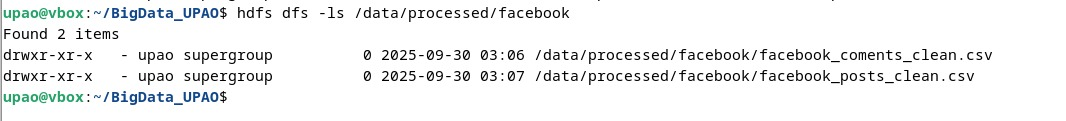

## Deteniendo sesion de spark

In [211]:
spark.stop()
del spark  # elimina la variable

In [212]:
try:
    spark
except NameError:
    print("SparkSession no está creada.")


SparkSession no está creada.
